This code is not fast, I wouldn't suggest running it with 10'000 measures if you don't have 20 minutes to spare waiting.
Enjoy.

In [142]:
from astropy.io import fits
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [143]:
Nbins=200 #this number is fixed!

#these can be changed if needed:
Nmeasures=100 #max=10000
ds=2 #changes the dataset used, can be 1,2,3
nmult=5 # it's the number of mutipoles we have

covtest=1 #every other value makes it so that the covariance test is skipped
plots=1 #every other value makes it so that the plots are skipped

In [144]:
#getting the data:

measures=np.zeros((nmult,Nbins,Nmeasures))

for n in np.arange(0, nmult):
    if (n % 2) == 0:#multipole 1 and 3 are 0, to avoid cycling over useless variables they're always skipped
        temp_measures=[]
        for i in np.arange(Nmeasures)+1:
            fname=f'data/MockMeasures_2PCF_Test{ds}/MockMeasures_2PCF_Correlation_MULTIPOLES_Test{ds}_{i}.fits'
            file = fits.open(fname)
            tabs=file[1].data.copy()
            temp_measures.append(tabs.field(n+1)) #for each measure field() gives the Nbins values of a multipole (0,2,4)
            if i==1:
                dist = tabs['SCALE'] # the scale column is the same for all measures
            del tabs
            file.close()
        
        measures[n]=np.asarray(temp_measures).transpose() #this way round we have all the values for one distance in the same row 

In [145]:
#np functions results:

mean=np.zeros((nmult,Nbins))
cov=np.zeros((nmult,Nbins,Nbins))
covA=np.zeros((nmult,nmult,Nbins*2,Nbins*2))
covB=np.zeros((nmult,nmult,Nbins,Nbins))

for n in np.arange(0, nmult):
    if (n % 2) == 0:
        mean[n]= np.mean(measures[n],axis=1)
        cov[n]= np.cov(measures[n])
        for m in np.arange(0,nmult):
            if m<=n and (m % 2) == 0:
                covA[n,m]=np.cov(measures[n],measures[m])
            covB[n,m,:,:]=covA[n,m,-Nbins:Nbins*2,0:Nbins]


In [146]:
# checking that np and I both know how to calculate the cov:
if covtest==1:
    mmax=[]
    for n in np.arange(0, nmult):
        vec1=[] 
        vec2=[]
        if (n % 2) == 0: 
            c=np.zeros((Nbins,Nbins),dtype=float)
            dmed=(np.sum(measures[n],axis=1))/Nmeasures
            for a in range(Nbins):
                for b in range(Nbins):
                    c[a,b]=(np.sum(measures[n,a]*measures[n,b]) - dmed[a]*dmed[b]*Nmeasures) / (Nmeasures-1)
                    d=np.abs(c[a,b]-cov[n,a,b])
                    vec1.append(d)
                    for m in np.arange(0,nmult):
                        if m<n and (m % 2) == 0:
                            cA=np.zeros((Nbins,Nbins),dtype=float)
                            dmedA=(np.sum(measures[m],axis=1))/Nmeasures
                            cA[a,b]=(np.sum(measures[n,a]*measures[m,b]) - dmed[a]*dmedA[b]*Nmeasures)/(Nmeasures-1)
                            dA=np.abs(cA[a,b]-covB[n,m,a,b])
                            vec2.append(dA)

            #print('Largest deviation between my calculation and numpy: {}'.format(np.max(np.asarray(vec1))))
            if (vec2):
                #print('Largest deviation between my calculation and numpy: {}'.format(np.max(np.asarray(vec2))))
                mmax.append(max(np.max(np.asarray(vec1)),np.max(np.asarray(vec2))))
                #print('Largest deviation between my calculation and numpy: {}'.format(max(np.max(np.asarray(vec1)),mmax)))
            else:
                mmax.append(np.max(np.asarray(vec1)))
                #print('Largest deviation between my calculation and numpy: {}'.format(np.max(np.asarray(vec1))))
    print('Largest deviation between my calculation and numpy: {}'.format(np.max(np.asarray(mmax))))

Largest deviation between my calculation and numpy: 2.481193253785728e-11


In [147]:
# correlation matrix
corr = np.zeros((nmult,Nbins,Nbins),dtype=float)
corrB = np.zeros((nmult,nmult,Nbins,Nbins),dtype=float)
for n in np.arange(0,nmult):
    if (n % 2) == 0:
        for a in range(Nbins):
            for b in range(Nbins):
                corr[n,a,b]=cov[n,a,b]/(cov[n,a,a]*cov[n,b,b])**0.5
                for m in np.arange(0,nmult):
                    if m<n and (m % 2) == 0:
                        corrB[n,m,a,b]=covB[n,m,a,b]/(covB[n,m,a,a]*covB[n,m,b,b])**0.5

In [148]:
if ds==1:
    sigs = [0.02, 0, 0.02, 0, 0.02]
    ls = [25,0, 50,0, 75]
elif ds==2:
    sigs = [0.02, 0,0.01,0, 0.005]
    ls = [50,0, 50,0, 50]
else:
    sigs = [0.02,0, 0.01,0, 0.005]
    ls = [5,0, 5,0, 5]
    
# Definitions to build the covariance matrices
def covf(x1, x2, sig, l):
    return sig**2.*np.exp(-(x1 - x2)**2./(2.*l**2.))

def covf1f2(x1, x2, sig1, l1, sig2, l2):
    return (np.sqrt(2.*l1*l2)*np.exp(-(np.sqrt((x1 - x2)**2.)**2./(l1**2. + l2**2.)))*sig1*sig2)/np.sqrt(l1**2. + l2**2.)

cov_th = np.zeros((nmult,Nbins,Nbins),dtype=float)
cov_thmix = np.zeros((nmult, nmult,Nbins,Nbins),dtype=float)
for n in np.arange(0,nmult):
    if (n % 2) == 0:
        for i in range(Nbins):
            for j in range(Nbins):
                cov_th[n,i,j] = covf(dist[i],dist[j],sigs[n],ls[n])
                for m in np.arange(0,nmult):
                    if m<n and (m % 2) == 0:
                        cov_thmix[n,m,i,j] = covf1f2(dist[i],dist[j],sigs[n],ls[n],sigs[m],ls[m])

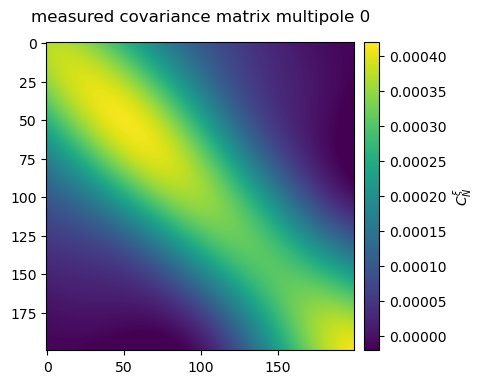

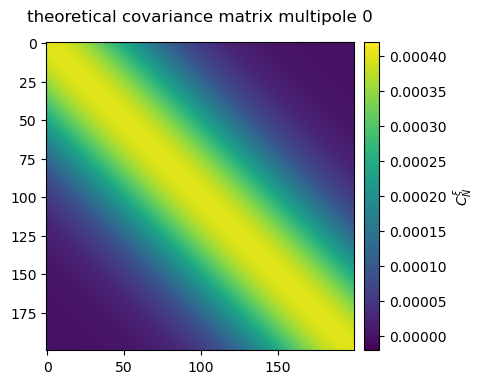

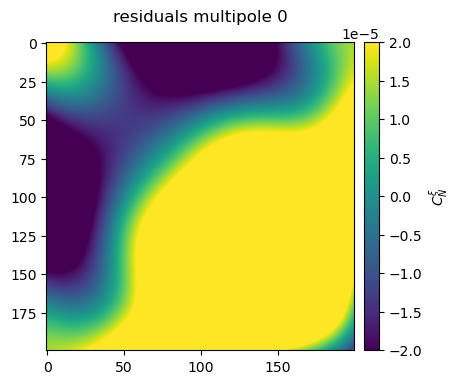

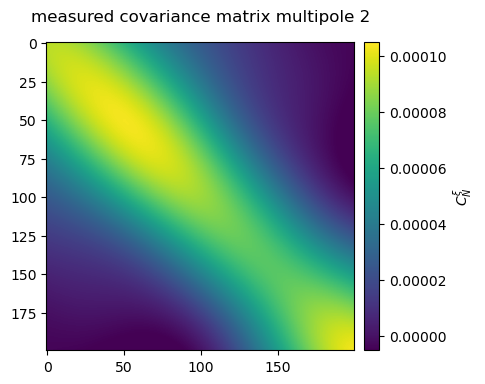

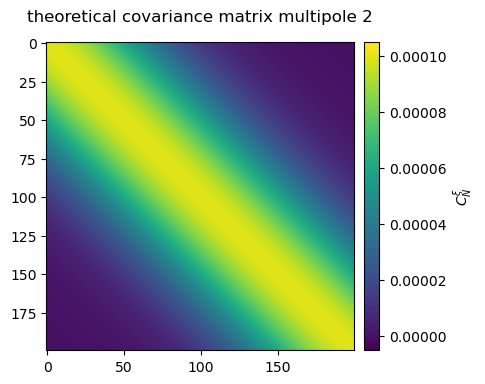

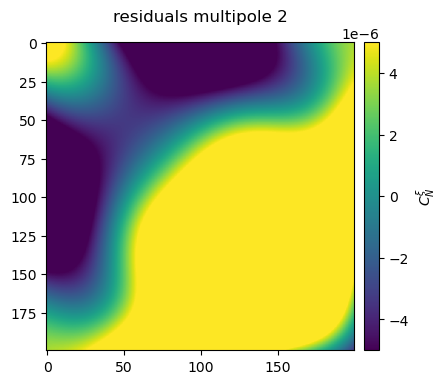

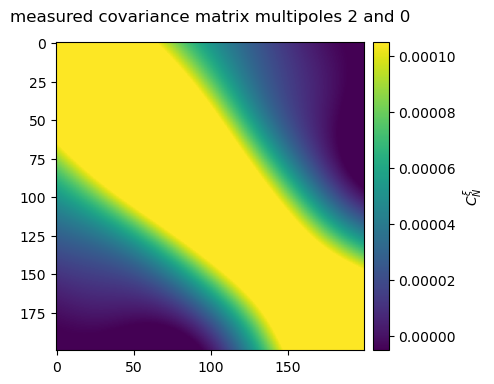

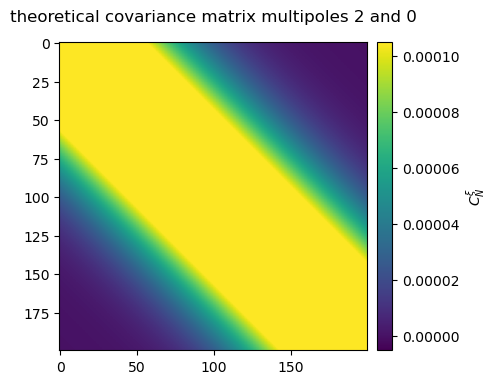

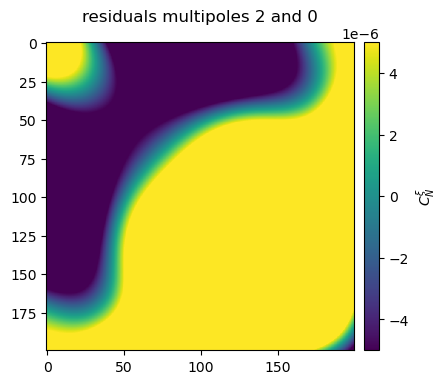

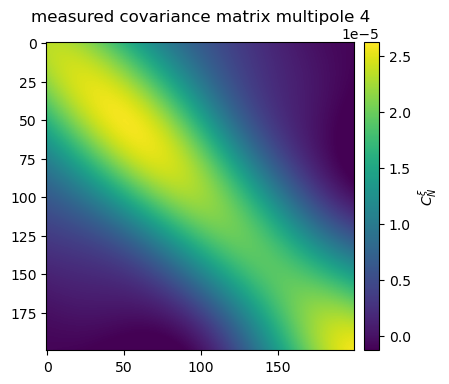

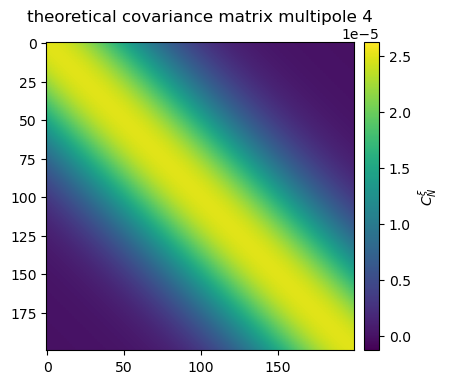

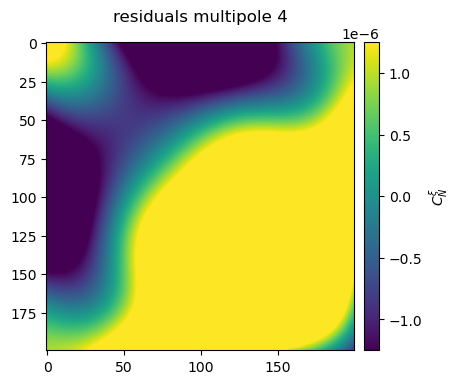

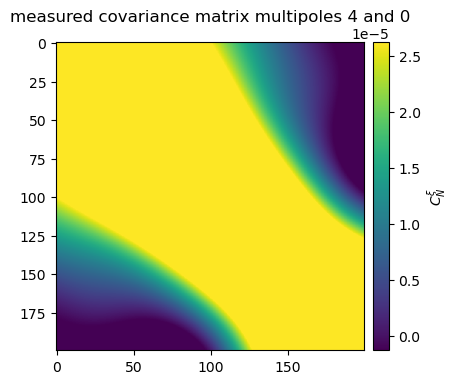

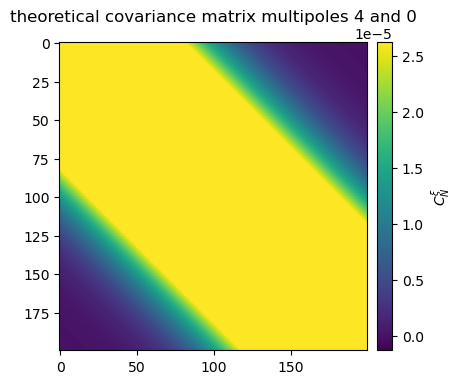

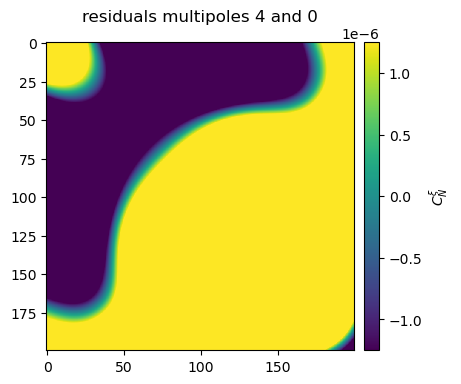

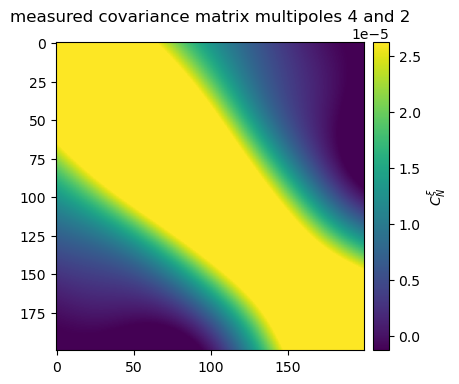

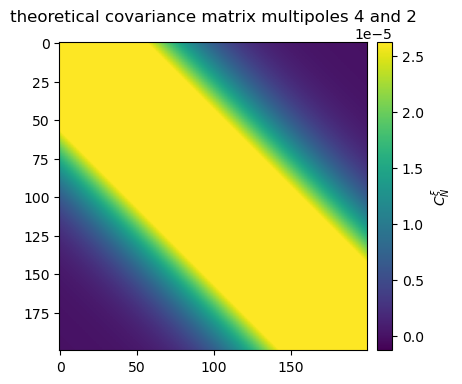

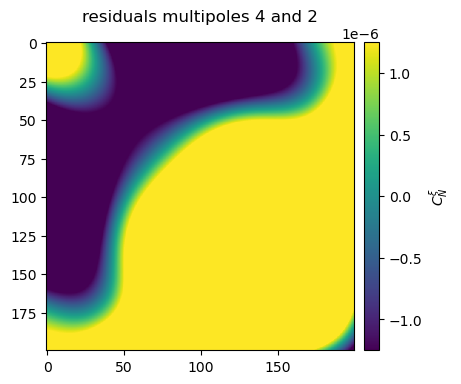

In [149]:
#plots
if plots==1:

    for n in np.arange(0,nmult):
        if (n % 2) == 0:
            gratio = (1. + 5. ** 0.5) / 2.

            dpi = 300
            #climit=max(np.max(theoretical_covariance),np.max(measured_covariance))
            cmin = -np.max(cov_th[n])*0.05
            cmax =  np.max(cov_th[n])*1.05

            # Matrix plot of measured covariance matrix
            fig = plt.figure(figsize=(6,4))
            plt.title(f'measured covariance matrix multipole {n}',pad=15)
            plt.imshow(cov[n], vmin=cmin, vmax=cmax)
            cbar = plt.colorbar(orientation="vertical", pad=0.02)
            cbar.set_label(r'$ C^{\xi}_{N}$')
            # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
            # plt.savefig(PLOTNAME,dpi = dpi)
            plt.show()


            # Matrix plot of theoretical covariance matrix
            fig = plt.figure(figsize=(6,4))
            plt.title(f'theoretical covariance matrix multipole {n}',pad=15)
            plt.imshow(cov_th[n], vmin=cmin, vmax=cmax)
            cbar = plt.colorbar(orientation="vertical", pad=0.02)
            cbar.set_label(r'$ C^{\xi}_{N}$')
            # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
            # plt.savefig(PLOTNAME,dpi = dpi)
            plt.show()

            # Matrix plot of theoretical covariance matrix
            fig = plt.figure(figsize=(6,4))
            plt.title(f'residuals multipole {n}',pad=15)
            plt.imshow(cov_th[n]-cov[n], vmin=cmin, vmax=-cmin)
            cbar = plt.colorbar(orientation="vertical", pad=0.02)
            cbar.set_label(r'$ C^{\xi}_{N}$')
            # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
            # plt.savefig(PLOTNAME,dpi = dpi)
            plt.show()
            
            for m in np.arange(0,nmult):
                if m<n and (m % 2) == 0:
                    fig = plt.figure(figsize=(6,4))
                    plt.title(f'measured covariance matrix multipoles {n} and {m}',pad=15)
                    plt.imshow(covB[n,m], vmin=cmin, vmax=cmax)
                    cbar = plt.colorbar(orientation="vertical", pad=0.02)
                    cbar.set_label(r'$ C^{\xi}_{N}$')
                    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
                    # plt.savefig(PLOTNAME,dpi = dpi)
                    plt.show()
                    
                    # Matrix plot of theoretical covariance matrix
                    fig = plt.figure(figsize=(6,4))
                    plt.title(f'theoretical covariance matrix multipoles {n} and {m}',pad=15)
                    plt.imshow(cov_thmix[n,m], vmin=cmin, vmax=cmax)
                    cbar = plt.colorbar(orientation="vertical", pad=0.02)
                    cbar.set_label(r'$ C^{\xi}_{N}$')
                    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
                    # plt.savefig(PLOTNAME,dpi = dpi)
                    plt.show()

                    # Matrix plot of theoretical covariance matrix
                    fig = plt.figure(figsize=(6,4))
                    plt.title(f'residuals multipoles {n} and {m}',pad=15)
                    plt.imshow((cov_thmix[n,m]-covB[n,m]), vmin=cmin, vmax=-cmin)
                    cbar = plt.colorbar(orientation="vertical", pad=0.02)
                    cbar.set_label(r'$ C^{\xi}_{N}$')
                    #PLOTNAME = 'Test%s_Measured_Matrix.png'%ds
                    #plt.savefig(PLOTNAME,dpi = dpi)
                    plt.show()

In [150]:
norm_residuals = np.zeros_like(cov_th)
norm_residualsmix = np.zeros((nmult, nmult,Nbins,Nbins),dtype=float)

for n in np.arange(0,nmult):
        if (n % 2) == 0:
            for i in range(Nbins):
                for j in range(Nbins):
                    rho2 = cov_th[n,i,j]**2./(np.sqrt(cov_th[n,i,i]*cov_th[n,j,j])**2.)
                    norm_residuals[n,i,j]=(cov_th[n,i,j]-cov[n,i,j])*np.sqrt((Nmeasures-1.)/((1.+rho2)*cov_th[n,i,i]*cov_th[n,j,j]))
                    for m in np.arange(0, nmult):
                        if (m % 2) == 0 and (m<n):
                            rmix=cov_thmix[n,m,i,j]**2/(np.sqrt(cov_thmix[n,m,i,i]*cov_thmix[n,m,j,j])**2)
                            norm_residualsmix[n,m,i,j]=(cov_thmix[n,m,i,j]-covB[n,m,i,j])*((Nmeasures-1)/((1.0+rmix)*cov_th[n,i,i]*cov_th[m,j,j]))**0.5

            
            rms_deviation=np.std(norm_residuals[n].reshape(Nbins**2))
            
            print(f"rms deviation of normalized residuals for multipole {n}: {rms_deviation}")
            
            if rms_deviation<1.1:
                print("PASSED ")
            else:
                print("FAILED! YOU ARE NOT A DALEK! EXTERMINATE! EXTERMINATE!!!!!!")
            for m in np.arange(0, nmult):
                if (m % 2) == 0 and (m<n): 
                    rmsmix_deviation=np.std(norm_residualsmix[n,m].reshape(Nbins**2))
                    print(f"A rms deviation of normalized residuals for multipoles {n} and {m}: {rmsmix_deviation}")
                    if rmsmix_deviation<1.1:
                        print("PASSED ")
                    else:
                        print("FAILED! YOU ARE NOT A DALEK! EXTERMINATE! EXTERMINATE!!!!!!")


rms deviation of normalized residuals for multipole 0: 0.773196288004206
PASSED 
rms deviation of normalized residuals for multipole 2: 0.7731962663617519
PASSED 
A rms deviation of normalized residuals for multipoles 2 and 0: 0.7731962771829796
PASSED 
rms deviation of normalized residuals for multipole 4: 0.7731962675469566
PASSED 
A rms deviation of normalized residuals for multipoles 4 and 0: 0.7731962777755813
PASSED 
A rms deviation of normalized residuals for multipoles 4 and 2: 0.7731962669543548
PASSED 
